In [1]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

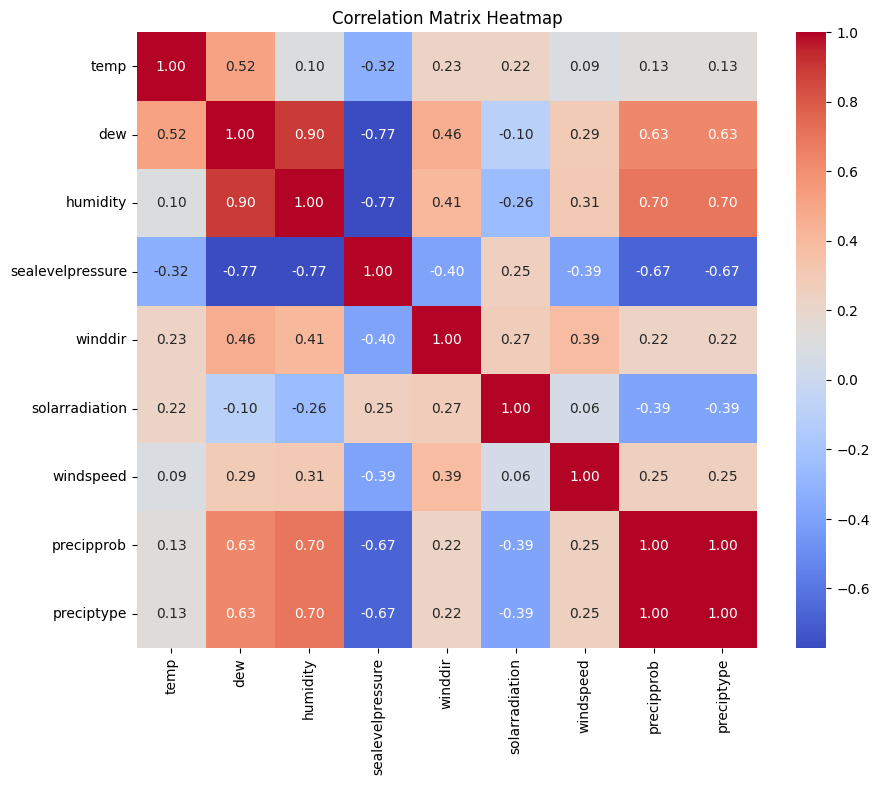

In [2]:

# Load the dataset
df = pd.read_csv("rainfall.csv")

# Convert datetime string to Python datetime object and set as the index
df["datetime"] = pd.to_datetime(df["datetime"], format="%d-%m-%Y")
df.set_index("datetime", inplace=True)

# Create a heatmap to visualize the correlation matrix
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()


In [3]:

# Create subplots for whole data visualization
plot_rows = 6
plot_cols = 1
fig = make_subplots(rows=plot_rows, cols=plot_cols)

# Add traces to the subplots
x = 0
for i in range(1, plot_rows + 1):
    for j in range(1, plot_cols + 1):
        fig.add_trace(
            go.Scatter(
                x=df.index, y=df[df.columns[x]].values, name=df.columns[x], mode="lines"
            ),
            row=i,
            col=j,
        )
        x += 1

# Format and display the figure
fig.update_layout(height=1200, width=1200, title_text="Daily Data")
fig.show()


In [4]:

# Columns to drop
columns_to_drop = ["windspeed", "precipprob", "preciptype"]
df = df.drop(columns=columns_to_drop)

# Select a specific date range
start_date = "2011-10-01"
end_date = "2025-12-31"
df = df[(df.index >= start_date) & (df.index <= end_date)]

# Specify column for prediction
to_predict = "temp"

# Specify the columns to use as features
features = ["dew", "humidity", "sealevelpressure"]
X = df[features]
y = df[to_predict]

# Perform a 70-30 train-test split
train_percentage = 0.7
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_percentage, test_size=1 - train_percentage, shuffle=False
)


In [5]:

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grid for SVR
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2, 0.5, 1.0]
}

# GridSearchCV to find the best SVR model
svr = GridSearchCV(SVR(), param_grid, cv=3)
svr.fit(X_train_scaled, y_train)
best_svr = svr.best_estimator_

# Make predictions on the test data
y_pred = best_svr.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best SVR Model:", best_svr)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)


Best SVR Model: SVR(C=10, epsilon=0.01)
Mean Squared Error: 0.01980768972736654
Mean Absolute Error: 0.09217561209566331
R-squared: 0.9937666760250091


In [6]:
best_svr

SVR(C=10, epsilon=0.01)

In [7]:
fig = make_subplots(rows=1, cols=1)

# Add trace for the entire temperature data
fig.add_trace(
    go.Scatter(
        x=df.index,
        y=df['temp'],
        name="Temperature Data",
        mode="lines",
        line=dict(color="blue"),
    ),
    row=1,
    col=1,
)

# Add trace for the test data
fig.add_trace(
    go.Scatter(
        x=X_test.index,
        y=y_test,
        name="Test Data",
        mode="lines",
        line=dict(color="blue"),
    ),
    row=1,
    col=1,
)

# Add trace for the predicted data
fig.add_trace(
    go.Scatter(
        x=X_test.index,
        y=y_pred,
        name="Predicted Data",
        mode="lines",
        line=dict(color="red"),
    ),
    row=1,
    col=1,
)

# Set the layout for the plot
fig.update_layout(
    title="Temperature Training Data, Test Data, and Predicted Data",
    xaxis_title="Date",
    yaxis_title="Temperature",
)

# Show the plot
fig.show()

In [8]:

# Evaluate the model on the training data
y_train_pred = best_svr.predict(X_train_scaled)
training_mse = mean_squared_error(y_train, y_train_pred)
print("Training MSE:", training_mse)

# Evaluate the model on the testing data
y_test_pred = best_svr.predict(X_test_scaled)
testing_mse = mean_squared_error(y_test, y_test_pred)
print("Testing MSE:", testing_mse)


Training MSE: 0.036825802047358636
Testing MSE: 0.01980768972736654


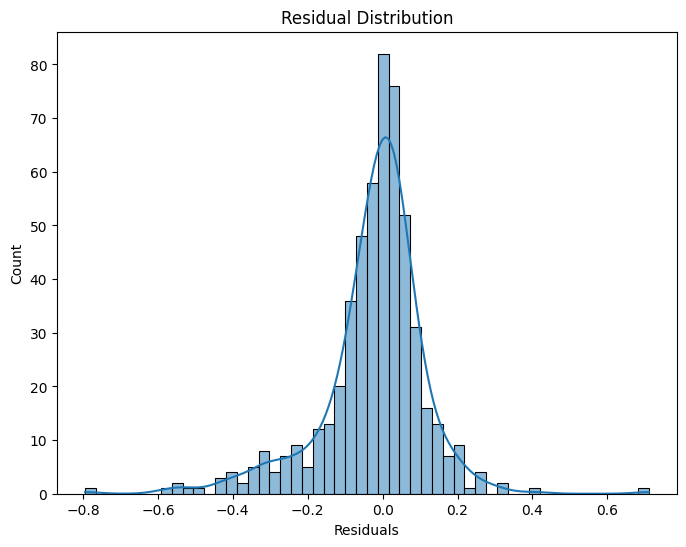

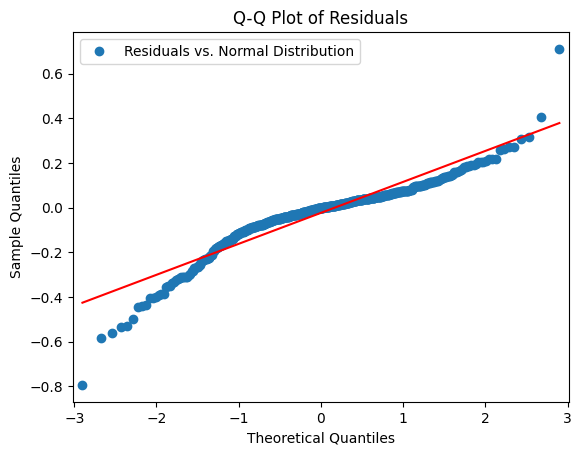

In [9]:
# Calculate residuals
residuals = y_test - y_test_pred

# Plot a histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.show()

# Create a Q-Q plot
qqplot(residuals, line="s", label="Residuals vs. Normal Distribution")
plt.title("Q-Q Plot of Residuals")
plt.legend()
plt.show()

In [10]:
scores = cross_val_score(best_svr, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
mean_cv_mse = -scores.mean()
std_cv_mse = scores.std()

print("Cross-Validation Mean MSE:", mean_cv_mse)
print("Cross-Validation Standard Deviation of MSE:", std_cv_mse)


Cross-Validation Mean MSE: 0.05888719249044109
Cross-Validation Standard Deviation of MSE: 0.024744038420217943
